In [1]:
import numpy as np
import pandas as pd 

In [2]:
churn_df = pd.read_csv('churn.csv')

In [3]:
#col_names = churn_df.columns.tolist()
#col_names

In [4]:
to_show = col_names[:6] + col_names[-6:]
to_show

NameError: name 'col_names' is not defined

In [5]:
churn_res = churn_df['Churn?']
y = np.where(churn_res=='True.', 1,0)
to_drop=['State', 'Area Code', 'Phone', 'Churn?']
churn_feat_space = churn_df.drop(to_drop, axis=1)
yes_no_cols = ["Int'l Plan", "VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] =='yes'
features = churn_feat_space.columns

In [26]:
X = churn_feat_space.as_matrix().astype(np.float)
from sklearn.preprocessing import StandardScaler

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X.shape)
print(np.unique(y))

(3333, 17)
[0 1]


In [28]:
from sklearn.model_selection import KFold

In [29]:
def run_cv(X,y,clf_class,**kwargs):
    kf = KFold(n_splits=5,shuffle = True)
    y_pred = y.copy()
    
    for train_index, test_index in kf.split(x): 
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred
    

In [30]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC

def accuracy(y_true,y_pred):
    return np.mean(y_true==y_pred)

In [36]:
print('SVM: %.3f' % accuracy(y, run_cv(x,y,SVC)))
print('SVM: %.3f' % accuracy(y, run_cv(x,y,RF)))
print('SVM: %.3f' % accuracy(y, run_cv(x,y,KNN)))
print('SVM: %.3f' % accuracy(y, run_cv(x,y,LR)))
print('SVM: %.3f' % accuracy(y, run_cv(x,y,GBC)))

SVM: 0.917
SVM: 0.946
SVM: 0.893
SVM: 0.861
SVM: 0.948


In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def draw_conf_matrices(conf_matrices, class_names):
    class_names = class_names.tolist()
    for cm in conf_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion Matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels(['']+class_names)
        ax.set_yticklabels(['']+class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
        
        
y = np.array(y)
class_names = np.unique(y)

conf_matrices = [('SVM', confusion_matrix(y,run_cv(x,y,SVC))),('RF', confusion_matrix(y,run_cv(x,y,RF))),('KNN', confusion_matrix(y,run_cv(x,y,KNN))),('LR', confusion_matrix(y,run_cv(x,y,LR))),('GBC', confusion_matrix(y,run_cv(x,y,GBC))) ]

[[2822   28]
 [ 241  242]]


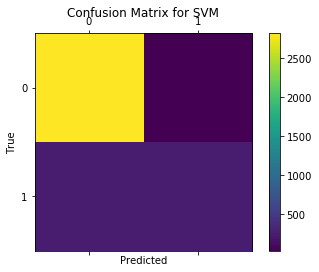

[[2824   26]
 [ 171  312]]


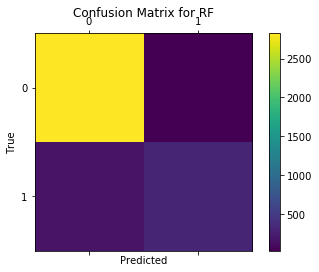

[[2809   41]
 [ 309  174]]


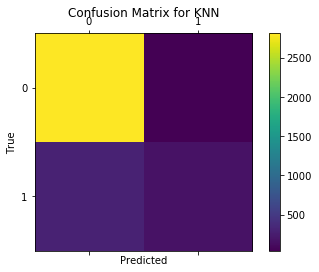

[[2767   83]
 [ 381  102]]


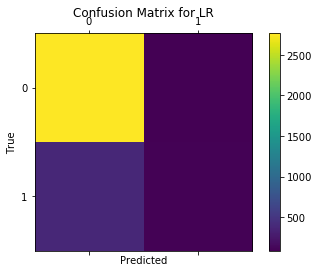

[[2814   36]
 [ 129  354]]


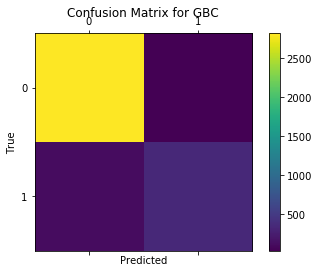

In [13]:
draw_conf_matrices(conf_matrices, class_names)

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('\tSVM Precision: %1.3f' % precision_score(y,run_cv(x,y,SVC)))
print('\tSVM Recall: %1.3f' % recall_score(y,run_cv(x,y,SVC)))
print('\tSVM F1: %1.3f' % f1_score(y,run_cv(x,y,SVC)))

print('\tRF Precision: %1.3f' % precision_score(y,run_cv(x,y,RF)))
print('\tRF Recall: %1.3f' % recall_score(y,run_cv(x,y,RF)))
print('\tRF F1: %1.3f' % f1_score(y,run_cv(x,y,RF)))

print('\tKNN Precision: %1.3f' % precision_score(y,run_cv(x,y,KNN)))
print('\tKNN Recall: %1.3f' % recall_score(y,run_cv(x,y,KNN)))
print('\tKNN F1: %1.3f' % f1_score(y,run_cv(x,y,KNN)))

print('\tLR Precision: %1.3f' % precision_score(y,run_cv(x,y,LR)))
print('\tLR Recall: %1.3f' % recall_score(y,run_cv(x,y,LR)))
print('\tLR F1: %1.3f' % f1_score(y,run_cv(x,y,LR)))

print('\tGBC Precision: %1.3f' % precision_score(y,run_cv(x,y,GBC)))
print('\tGBC Recall: %1.3f' % recall_score(y,run_cv(x,y,GBC)))
print('\tGBC F1: %1.3f' % f1_score(y,run_cv(x,y,GBC)))

	SVM Precision: 0.887
	SVM Recall: 0.513
	SVM F1: 0.647
	RF Precision: 0.929
	RF Recall: 0.648
	RF F1: 0.768
	KNN Precision: 0.770
	KNN Recall: 0.366
	KNN F1: 0.491
	LR Precision: 0.576
	LR Recall: 0.203
	LR F1: 0.312
	GBC Precision: 0.915
	GBC Recall: 0.733
	GBC F1: 0.818


SVM: 


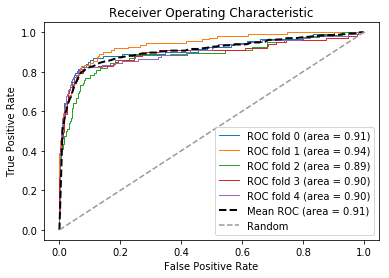

RF: 


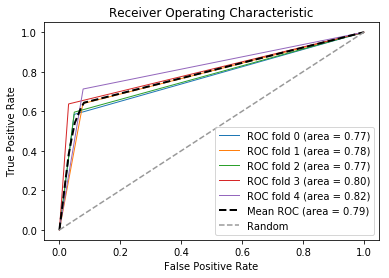

KNN: 


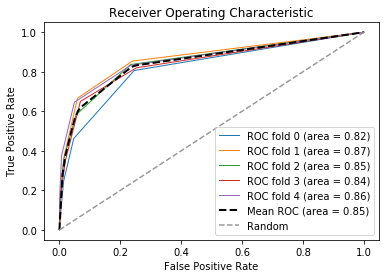

LR: 


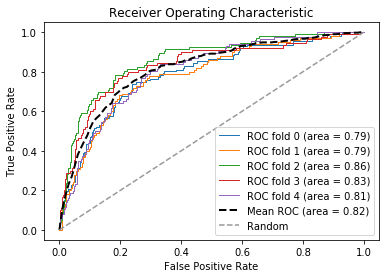

GBC: 


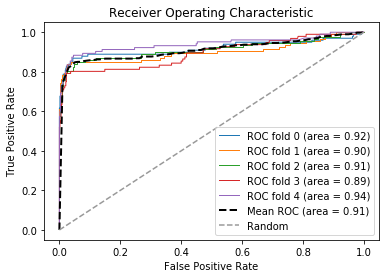

In [38]:
from sklearn.metrics import roc_curve, auc 
from scipy import interp 
def plot_roc(X,y,clf_class,**kwargs):
    kf = KFold(n_splits = 5,shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    all_tpr = []
    for i,(train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr,tpr,thresholds = roc_curve(y[test_index], y_prob[test_index,1])
        mean_tpr += interp(mean_fpr, fpr,tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr,tpr,lw=1,label = 'ROC fold %d (area = %0.2f)' % (i,roc_auc))
    mean_tpr /= kf.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr,mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--', label = 'Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0,1],[0,1], '--', color = (0.6, 0.6,0.6), label = 'Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = 'lower right')
    plt.show()
    
print('SVM: ')
plot_roc(X,y,SVC,probability = True)
print('RF: ')
plot_roc(X,y,RF,n_estimators = True)
print('KNN: ')
plot_roc(X,y,KNN)
print('LR: ')
plot_roc(X,y,LR)
print('GBC: ')
plot_roc(X,y,GBC)

Feature Ranking: 
1. Account Length (0.184829)
2. Int'l Plan (0.112314)
3. VMail Plan (0.086978)
4. VMail Message (0.079132)
5. Day Mins (0.059495)
6. Day Calls (0.038185)
7. Day Charge (0.028353)
8. Eve Mins (0.027350)
9. Eve Calls (0.022094)
10. Eve Charge (0.021589)


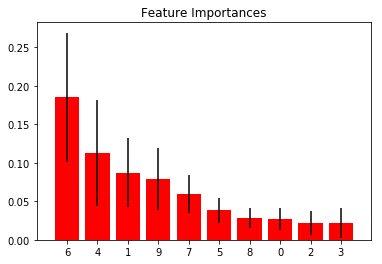

In [44]:
from sklearn.model_selection import train_test_split
train_index, test_index = train_test_split(churn_df.index)
forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])
importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]
print('Feature Ranking: ')
for f in range(10):
    print('%d. %s (%f)' % (f + 1, features[f], importances[indices[f]]))
    
plt.figure()
plt.title('Feature Importances')
plt.bar(range(10), importances[indices], yerr = std[indices], color = 'r', align = 'center')
plt.xticks(range(10), indices)
plt.xlim([-1,10])
plt.show()

In [55]:
def run_prob(X,y,clf_class, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    y_prob = np.zeros((len(y), 2))
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train  = y[train_index]
        clf =clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
pred_prob = run_prob(X,y,RF,n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1
counts = pd.value_counts(pred_churn)

true_prob = {}
for prob in counts.index:
   true_prob[prob]=np.mean(is_churn[pred_churn == prob])
   true_prob = pd.Series(true_prob)
    
counts = pd.concat([counts,true_prob],axis=1).reset_index()
counts.columns = ['pred_prob','count','true_prob']
print(counts)

    pred_prob  count  true_prob
0         0.0   1795   0.031755
1         0.1    671   0.017884
2         0.2    261   0.034483
3         0.3    121   0.123967
4         0.8     93   0.913978
5         0.9     81   0.987654
6         0.4     68   0.382353
7         0.7     67   0.910448
8         1.0     65   1.000000
9         0.5     56   0.464286
10        0.6     55   0.854545
